# Dota 2 Ward Data Analysis

This notebook analyzes ward placement data from recent TI BO5 games to provide insights on:
- Ward placement patterns by team (Radiant/Dire)
- Heatmaps showing popular ward locations
- Temporal patterns of ward placements
- Clustering of ward locations
- Contested areas between teams
- Strategic recommendations for ward placement

## Data Description
- Data extracted from recent TI BO5 games
- Coordinate system with (0,0) at bottom-left corner
- Ward types: OBSERVER and SENTRY
- Actions: SPAWN and DESPAWN
- Team identification: Radiant (player IDs 0-4) and Dire (player IDs >4)

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Constants for Dota 2 map coordinates
# Based on the example (86, 150) being near the center of top-left quarter of the map
# The full map would be approximately 172x300 units
"""
Note: data collected from stratz.com but it doesn't fit well known (17664, 16643) coordinate system.
As for the non-actual coordinate system, the heatmap is only examples, DO NOT use it in real cases.
You can modify the MAP_WIDTH and MAP_HEIGHT to meet your cases.
"""
MAP_WIDTH = 436 # corrected with coordinates from "https://docs.bayesesports.com/docs-live-data/message-schema/misc/map_coord"
MAP_HEIGHT = 411

# File paths
CSV_PATH = "ward_events.csv"

In [2]:
# Load and clean the data
df = pd.read_csv(CSV_PATH)

# Data type conversion and cleaning
df['time'] = pd.to_numeric(df['time'], errors='coerce')
df['positionX'] = pd.to_numeric(df['positionX'], errors='coerce')
df['positionY'] = pd.to_numeric(df['positionY'], errors='coerce')
df = df.dropna(subset=['positionX', 'positionY', 'time'])
df['isRadiant'] = df['isRadiant'].astype(bool)
df['wardType'] = df['wardType'].astype(str)

# Add round information (assuming match_id changes between rounds)
df['round'] = df.groupby('match_id').ngroup() + 1
df['round'] = df['round'].astype(int)

# Add minute column for temporal analysis
df['minute'] = (df['time'] / 60).astype(int)

# Display basic information
print(f"Loaded {len(df)} ward events")
print(f"Number of rounds: {df['round'].nunique()}")
print(f"Rounds: {sorted(df['round'].unique())}")
print(f"\nData sample:")
df.head()

Loaded 1083 ward events
Number of rounds: 5
Rounds: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

Data sample:


,action,fromPlayer,indexId,isRadiant,match_id,playerDestroyed,positionX,positionY,time,wardType,round,minute
0,SPAWN,128,1554,False,8461476910,NaN,130,116,-61,OBSERVER,1,-1
1,SPAWN,4,1559,True,8461476910,NaN,140,92,-61,OBSERVER,1,-1
2,SPAWN,132,1564,False,8461476910,NaN,130,96,-51,OBSERVER,1,0
3,SPAWN,4,1569,True,8461476910,NaN,166,100,-43,SENTRY,1,0
4,SPAWN,1,1573,True,8461476910,NaN,118,138,-34,OBSERVER,1,0


In [3]:
# Basic statistics and data overview
print("=== DATA OVERVIEW ===")
print(f"Total events: {len(df)}")
print(f"\nEvents by action:")
print(df['action'].value_counts())
print(f"\nEvents by ward type:")
print(df['wardType'].value_counts())
print(f"\nEvents by team:")
team_counts = df['isRadiant'].value_counts()
print(f"Radiant: {team_counts[True]} ({team_counts[True]/len(df)*100:.1f}%)")
print(f"Dire: {team_counts[False]} ({team_counts[False]/len(df)*100:.1f}%)")
print(f"\nEvents by round:")
print(df['round'].value_counts().sort_index())

# Time range
print(f"\nTime range: {df['time'].min():.0f} to {df['time'].max():.0f} seconds")
print(f"Game duration: {(df['time'].max() - df['time'].min())/60:.1f} minutes")

=== DATA OVERVIEW ===
Total events: 1083

Events by action:
action
SPAWN      563
DESPAWN    520
Name: count, dtype: int64

Events by ward type:
wardType
SENTRY      691
OBSERVER    392
Name: count, dtype: int64

Events by team:
Radiant: 547 (50.5%)
Dire: 536 (49.5%)

Events by round:
round
1    258
2    184
3    202
4    171
5    268
Name: count, dtype: int64

Time range: -61 to 3512 seconds
Game duration: 59.5 minutes


In [4]:
# Helper function to assign grid cells for spatial analysis
def cell_id(x, y, cell_size=8):
    """Assign a grid cell ID to a coordinate"""
    cx = int(min(MAP_WIDTH-1, max(0, x)) // cell_size)
    cy = int(min(MAP_HEIGHT-1, max(0, y)) // cell_size)
    return f"{cx}_{cy}"

# Add cell information to dataframe
df['cell'] = df.apply(lambda r: cell_id(r['positionX'], r['positionY']), axis=1)

print("Grid cell assignment complete")
print(f"Unique cells: {df['cell'].nunique()}")

Grid cell assignment complete
Unique cells: 164


In [5]:
# Heatmap visualization function
def ward_heatmap(df_data, team_is_radiant, ward_type=None, bins=64, cmap='magma'):
    """Generate a heatmap of ward placements"""
    # Filter data
    sub = df_data[df_data['isRadiant'] == team_is_radiant]
    if ward_type:
        sub = sub[sub['wardType'] == ward_type]
    
    # Extract coordinates
    x = sub['positionX'].values
    y = sub['positionY'].values
    
    # Check if data exists
    if len(x) == 0:
        print("No wards for this filter.")
        return None
    
    # Create 2D histogram
    heat, xedges, yedges = np.histogram2d(x, y, bins=bins,
                                          range=[[0, MAP_WIDTH], [0, MAP_HEIGHT]])
    heat = np.flipud(heat.T)
    
    # Plot
    plt.figure(figsize=(12, 10))
    plt.imshow(heat, extent=[0, MAP_WIDTH, 0, MAP_HEIGHT], origin='lower', cmap=cmap, aspect='auto')
    plt.colorbar(label='Ward density')
    
    # Title
    team_name = 'Radiant' if team_is_radiant else 'Dire'
    ward_name = ward_type if ward_type else 'ALL'
    title = f'{team_name} {ward_name} heatmap'
    plt.title(title, fontsize=16)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    
    # Show plot
    plt.show()
    
    return heat

Generating heatmaps...


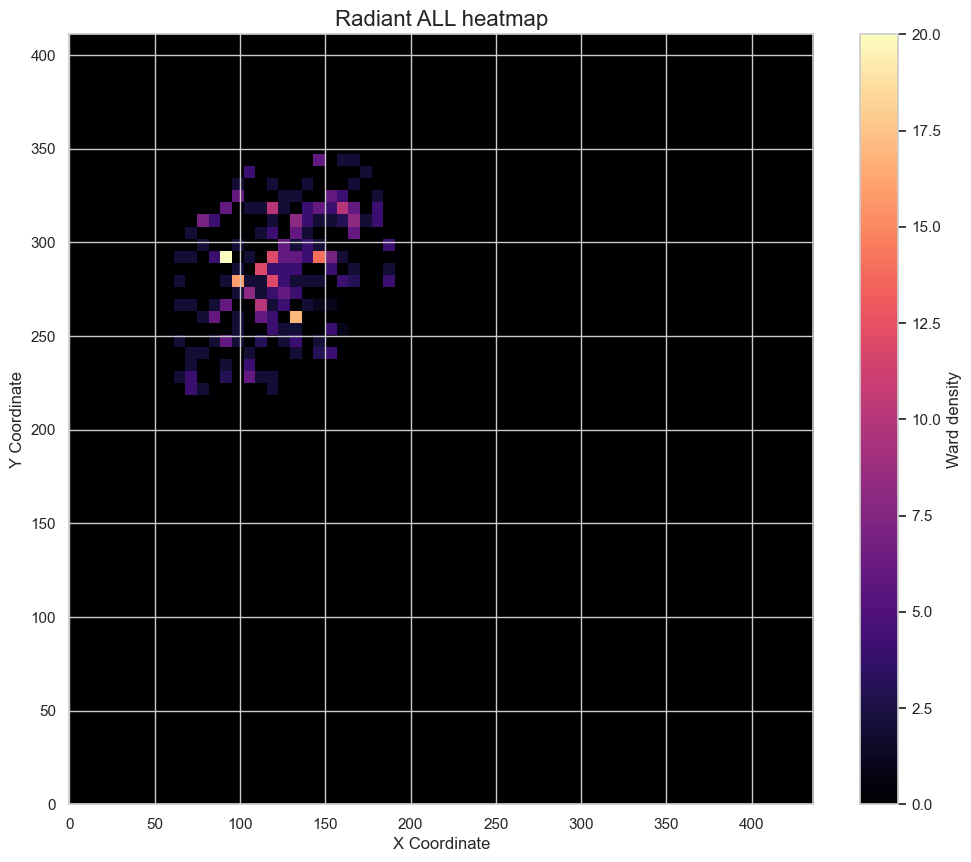

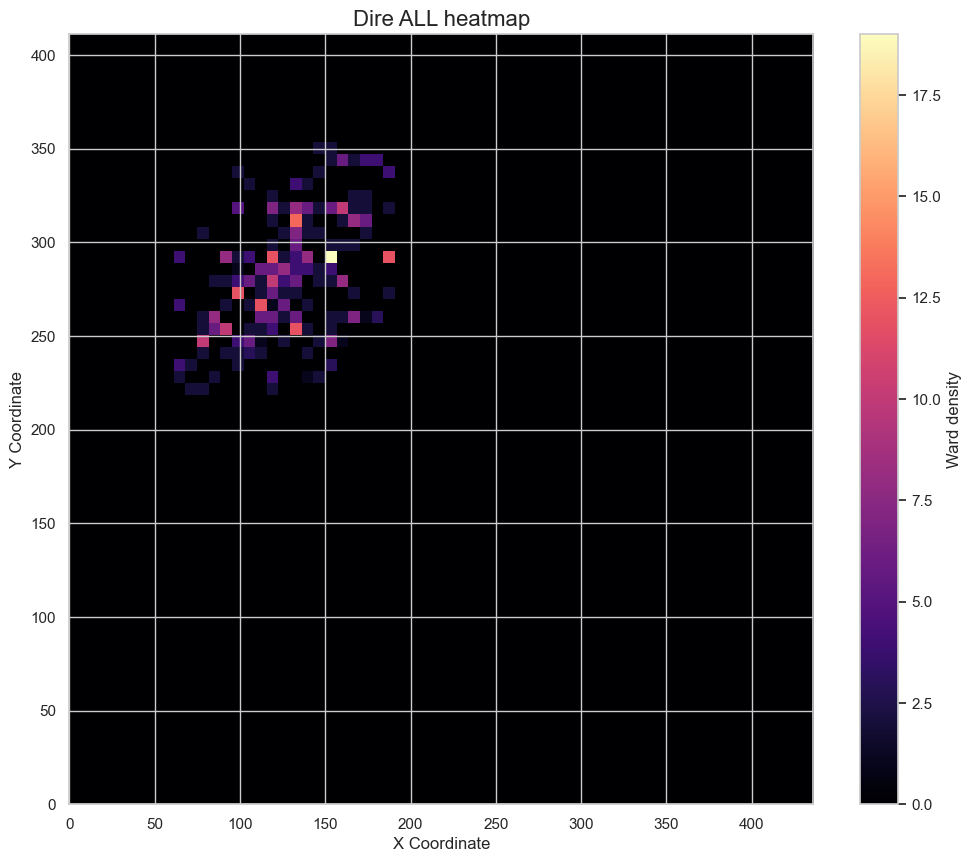

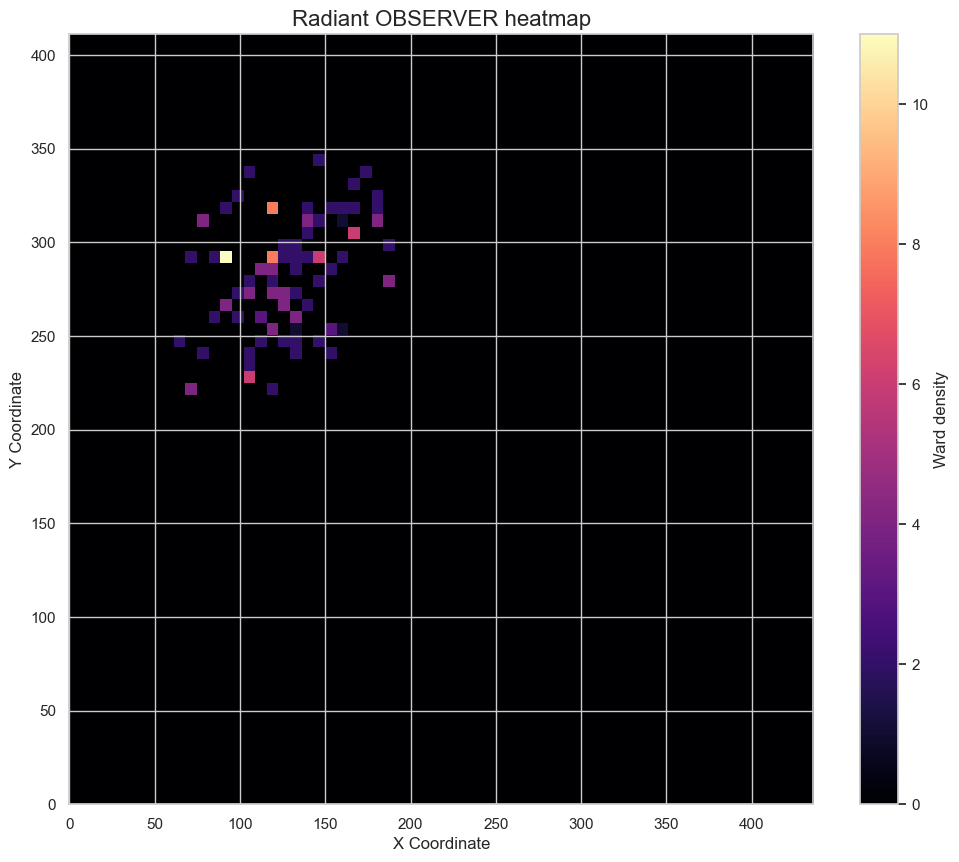

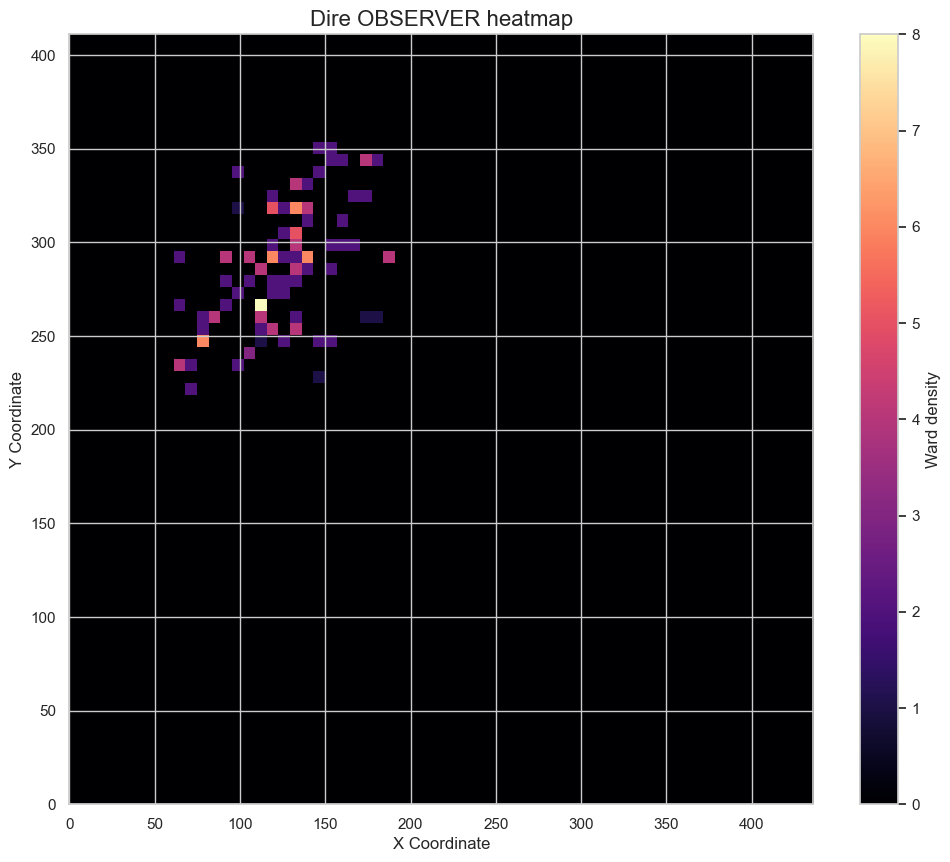

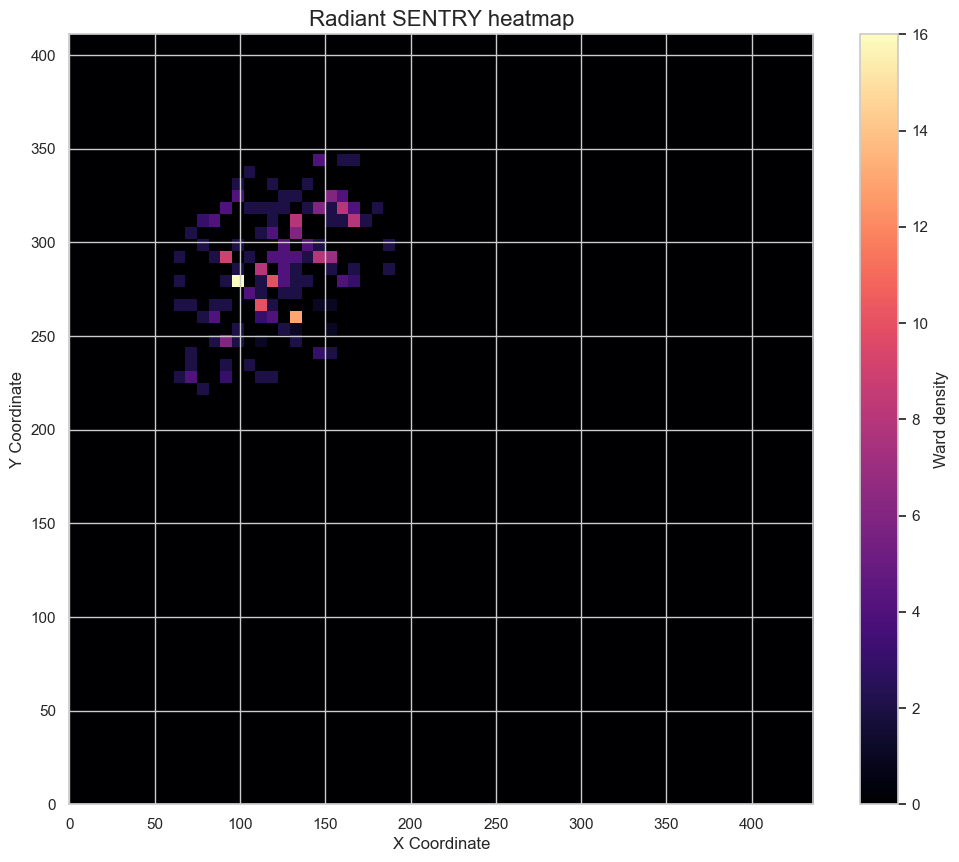

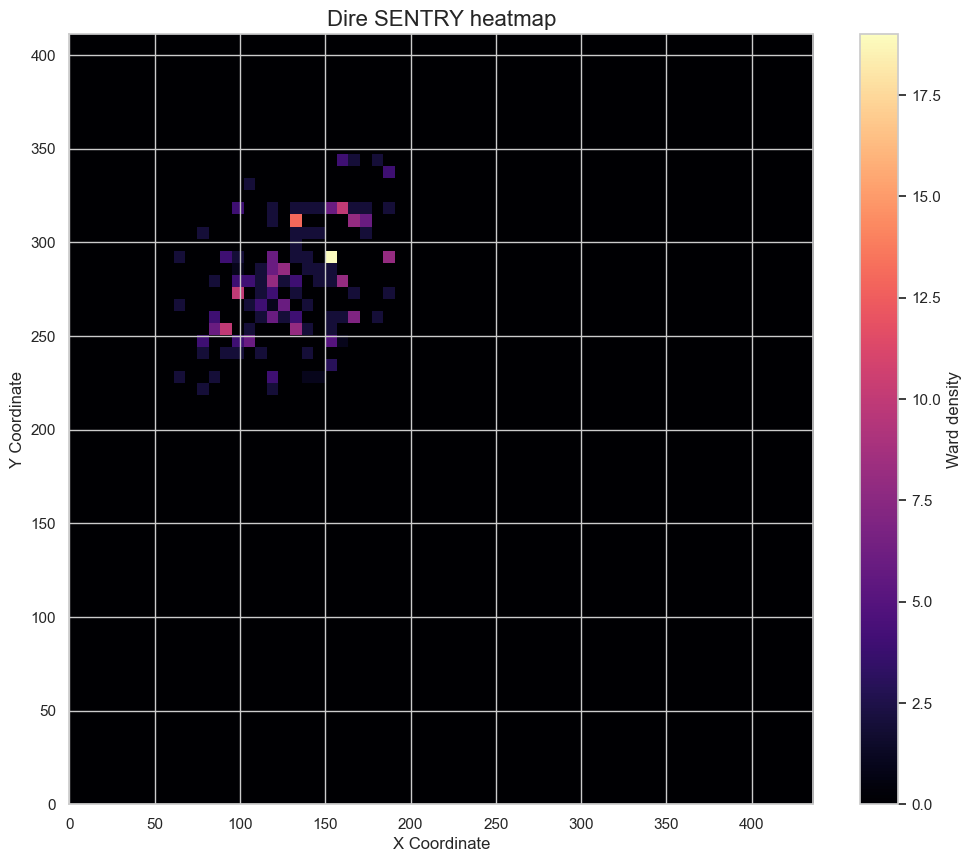

Heatmaps generated


In [6]:
# Generate heatmaps for both teams
print("Generating heatmaps...")

# Generate heatmaps for both teams
ward_heatmap(df, True, None, bins=64)
ward_heatmap(df, False, None, bins=64)

# Generate heatmaps by ward type
for ward_type in ['OBSERVER', 'SENTRY']:
    ward_heatmap(df, True, ward_type, bins=64)
    ward_heatmap(df, False, ward_type, bins=64)

print("Heatmaps generated")

In [7]:
# Ward clustering function
def cluster_wards(df_data, eps=10, min_samples=2):
    """Cluster ward placements using DBSCAN"""
    coords = df_data[['positionX', 'positionY']].values
    
    if len(coords) == 0:
        return df_data.assign(cluster=np.array([])), pd.DataFrame()
    
    # Apply DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    df_data = df_data.copy()
    df_data['cluster'] = clustering.labels_
    
    # Summarize clusters
    clusters = df_data[df_data['cluster'] != -1].groupby('cluster').agg(
        count=('cluster', 'size'),
        median_x=('positionX', 'median'),
        median_y=('positionY', 'median'),
        median_minute=('minute', 'median'),
        common_wardType=('wardType', lambda s: s.mode().iloc[0] if not s.mode().empty else ''),
        radiant_count=('isRadiant', lambda x: sum(x)),
        dire_count=('isRadiant', lambda x: sum(~x))
    ).reset_index().sort_values('count', ascending=False)
    
    return df_data, clusters

In [8]:
# Perform clustering analysis
print("Performing clustering analysis...")

# Cluster all wards
df_clustered, clusters = cluster_wards(df, eps=10, min_samples=2)

# Display cluster information
print(f"Found {len(clusters)} clusters with {clusters['count'].sum()} ward placements")
print("Top 10 clusters:")
print(clusters.head(10)[['cluster', 'count', 'median_x', 'median_y', 'common_wardType']])

# Cluster analysis by team
for team_name, is_radiant in [('Radiant', True), ('Dire', False)]:
    team_data = df[df['isRadiant'] == is_radiant]
    _, team_clusters = cluster_wards(team_data, eps=10, min_samples=2)
    
    print(f"\n{team_name} clusters: {len(team_clusters)} clusters with {team_clusters['count'].sum()} ward placements")
    if not team_clusters.empty:
        print("Top 5 clusters:")
        print(team_clusters.head(5)[['cluster', 'count', 'median_x', 'median_y', 'common_wardType']])

Performing clustering analysis...
Found 3 clusters with 1083 ward placements
Top 10 clusters:
   cluster  count  median_x  median_y common_wardType
0        0   1056     124.0     128.0          SENTRY
1        1     24     188.0     118.0          SENTRY
2        2      3     146.0     186.0          SENTRY

Radiant clusters: 14 clusters with 547 ward placements
Top 5 clusters:
   cluster  count  median_x  median_y common_wardType
0        0    470     122.0     122.0          SENTRY
1        1     18      70.0     182.0          SENTRY
6        6     14     153.0     167.0        OBSERVER
4        4      6     188.0     132.0        OBSERVER
9        9      6     144.0      68.0          SENTRY

Dire clusters: 16 clusters with 536 ward placements
Top 5 clusters:
   cluster  count  median_x  median_y common_wardType
0        0    396     124.0     134.0          SENTRY
1        1     46     164.0      92.0          SENTRY
2        2     34     158.0      70.0        OBSERVER
5        

In [9]:
# Temporal analysis function
def plot_time_series(df_round, team_is_radiant):
    """Plot ward placements over time for a specific round"""
    sub = df_round[df_round['isRadiant'] == team_is_radiant]
    
    if sub.empty:
        print("No data for team/time series.")
        return
    
    # Group by minute and ward type
    series = sub.groupby(['minute', 'wardType']).size().unstack(fill_value=0)
    
    # Plot
    plt.figure(figsize=(15, 6))
    ax = series.plot(kind='bar', stacked=True)
    
    team_name = 'Radiant' if team_is_radiant else 'Dire'
    title = f'Ward placements over time - {team_name} (round={df_round["round"].iloc[0]})'
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Game Minute', fontsize=12)
    ax.set_ylabel('Number of Wards', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Ward Type')
    plt.tight_layout()
    
    # Show plot
    plt.show()

Performing temporal analysis with round splitting...

Round 1 temporal analysis:


<Figure size 1500x600 with 0 Axes>

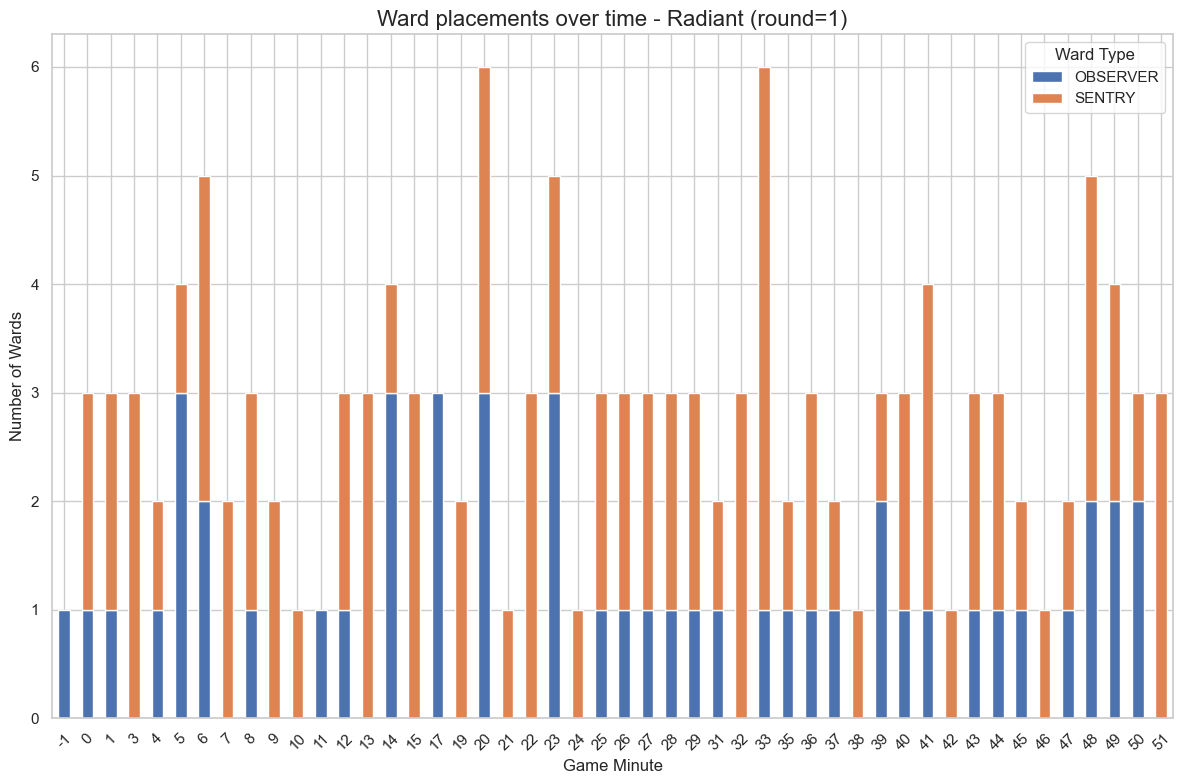

<Figure size 1500x600 with 0 Axes>

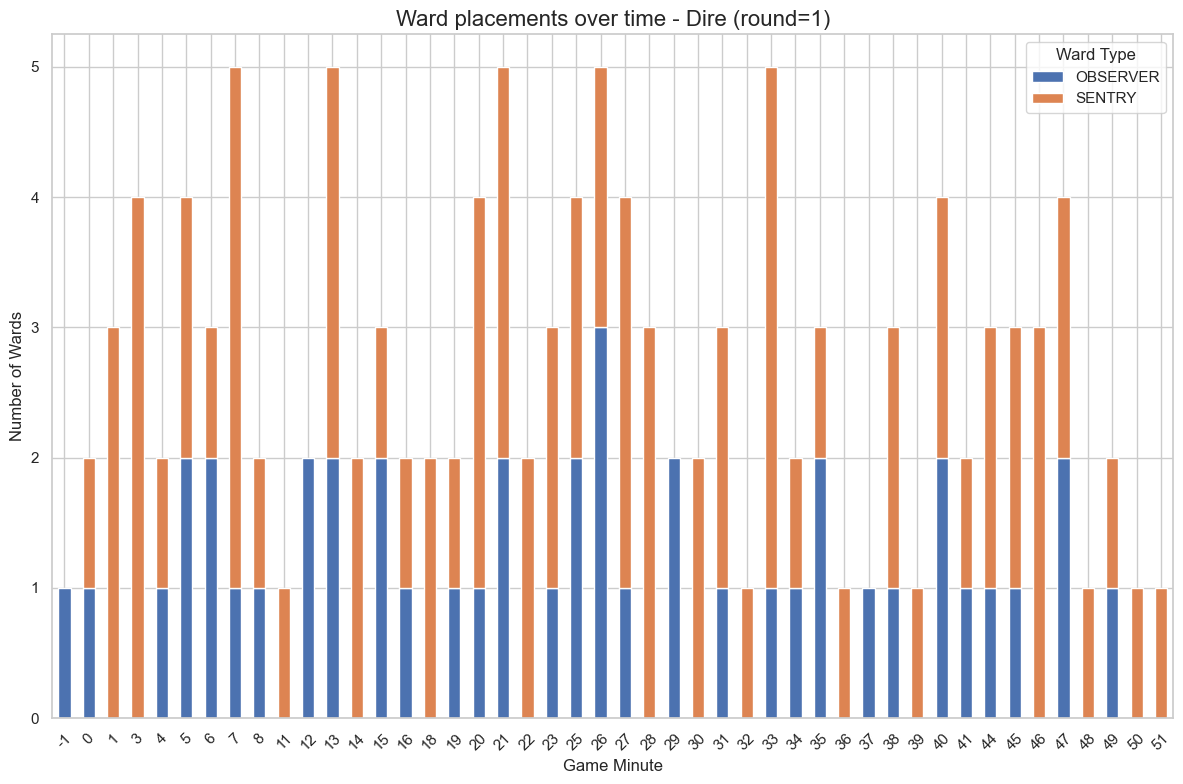

  Radiant: 48 OBSERVER, 87 SENTRY wards
  Dire: 44 OBSERVER, 79 SENTRY wards

Round 2 temporal analysis:


<Figure size 1500x600 with 0 Axes>

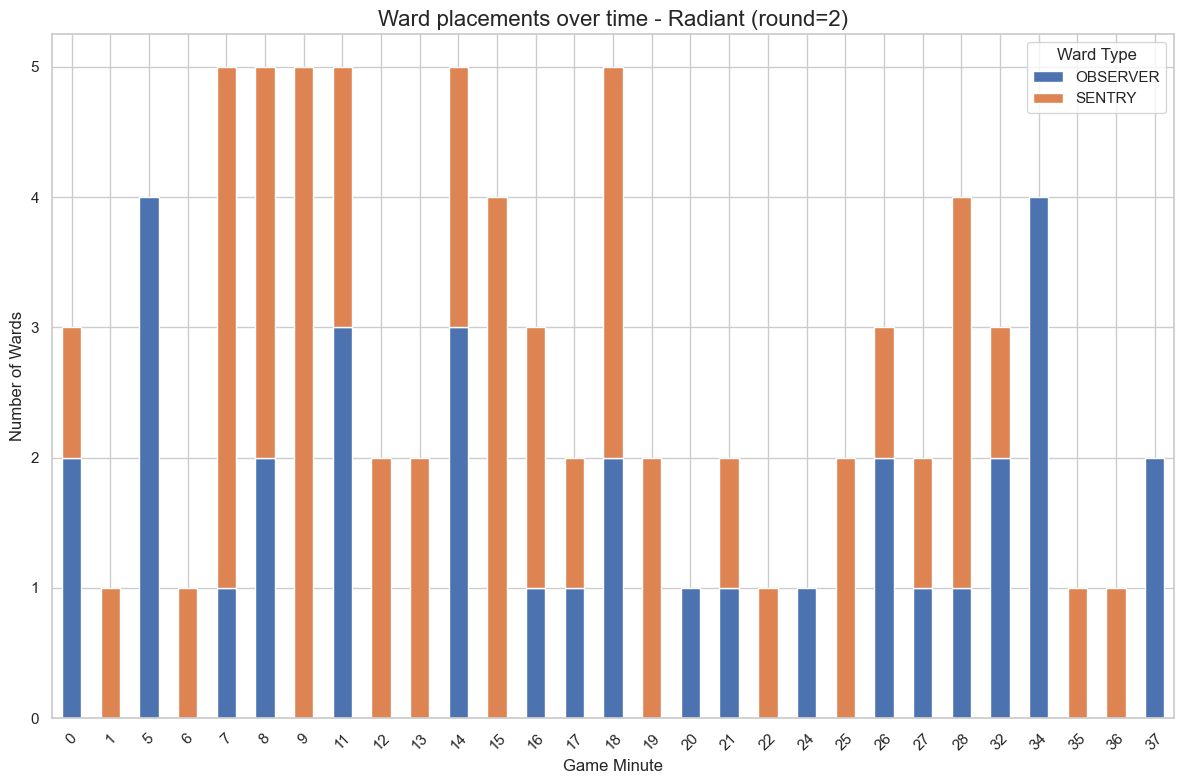

<Figure size 1500x600 with 0 Axes>

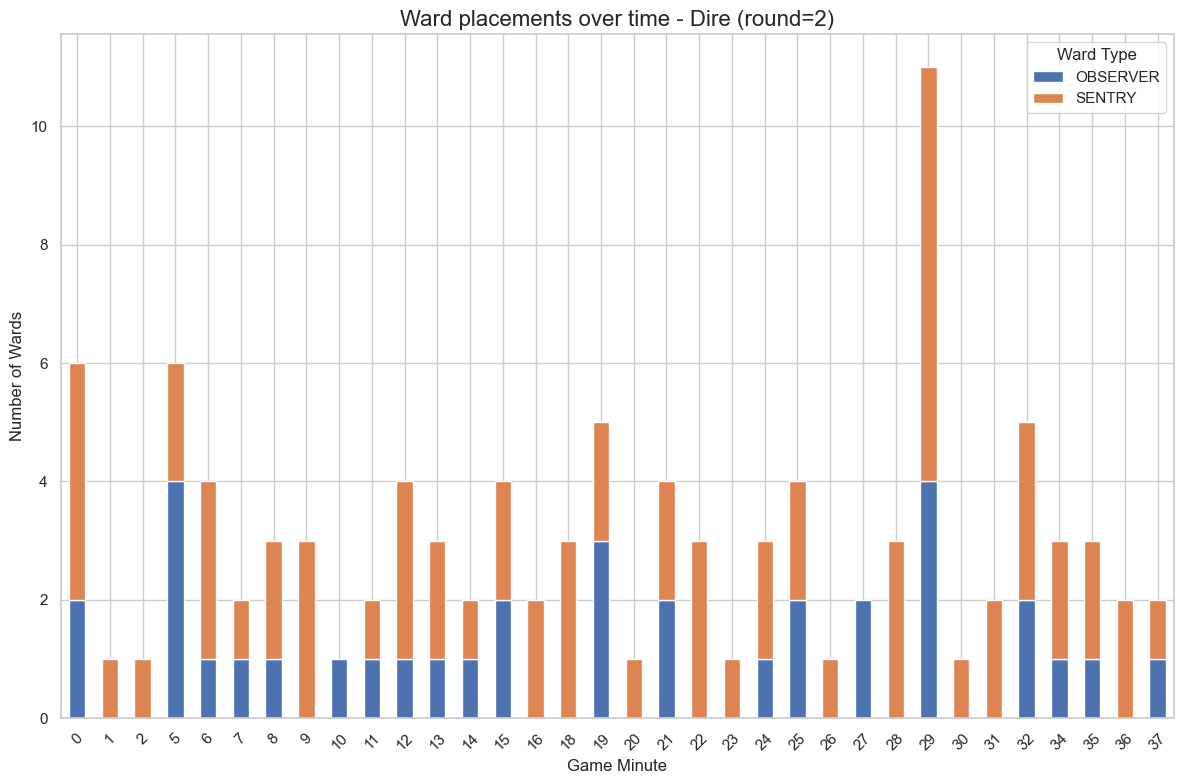

  Radiant: 34 OBSERVER, 47 SENTRY wards
  Dire: 35 OBSERVER, 68 SENTRY wards

Round 3 temporal analysis:


<Figure size 1500x600 with 0 Axes>

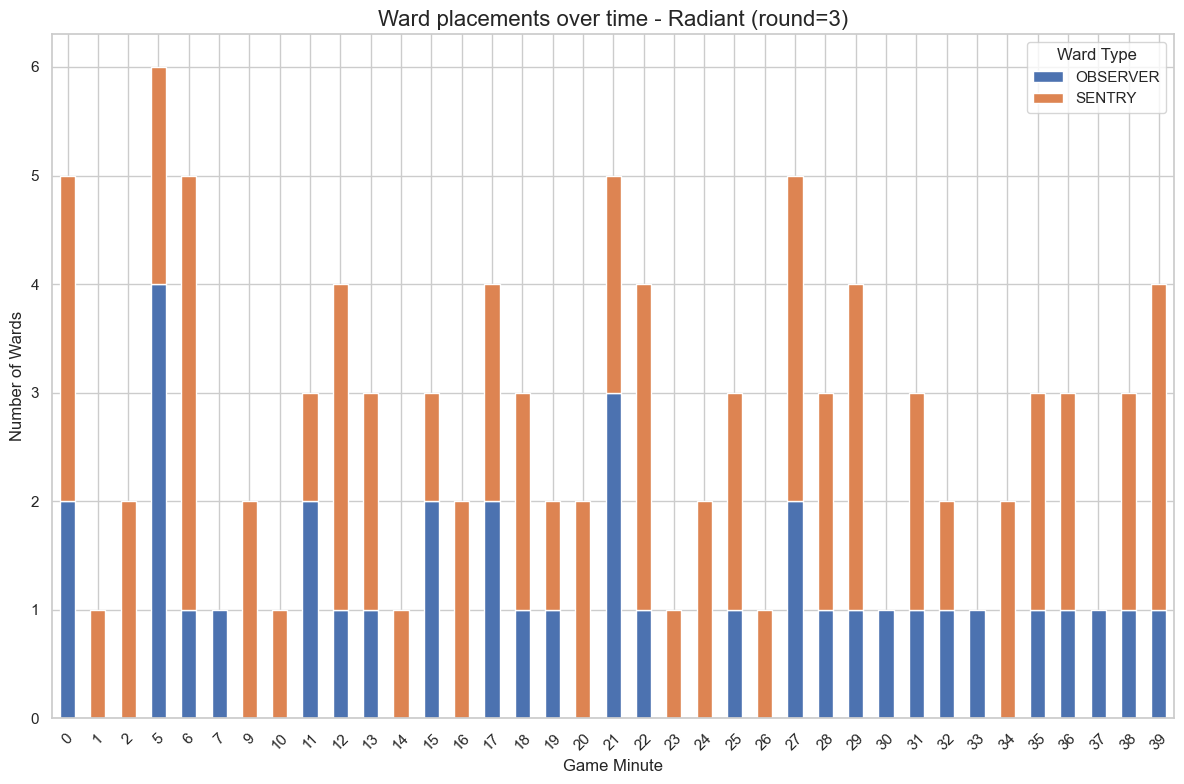

<Figure size 1500x600 with 0 Axes>

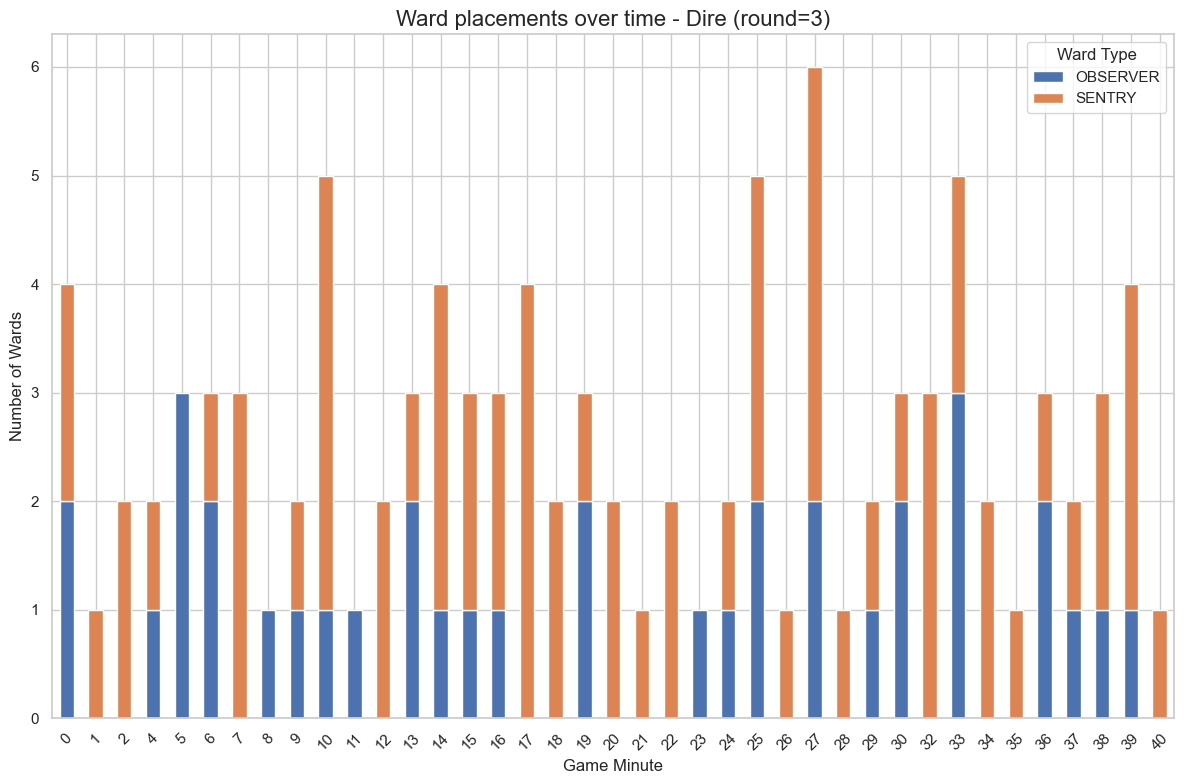

  Radiant: 36 OBSERVER, 65 SENTRY wards
  Dire: 36 OBSERVER, 65 SENTRY wards

Round 4 temporal analysis:


<Figure size 1500x600 with 0 Axes>

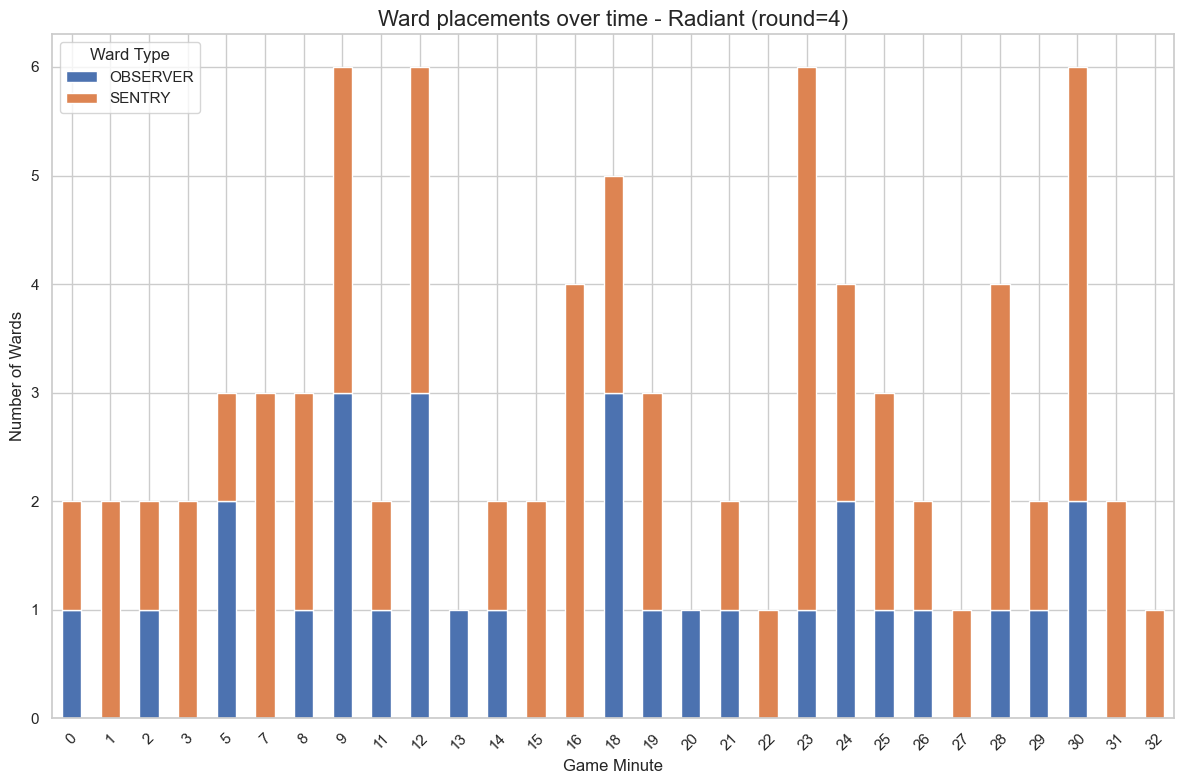

<Figure size 1500x600 with 0 Axes>

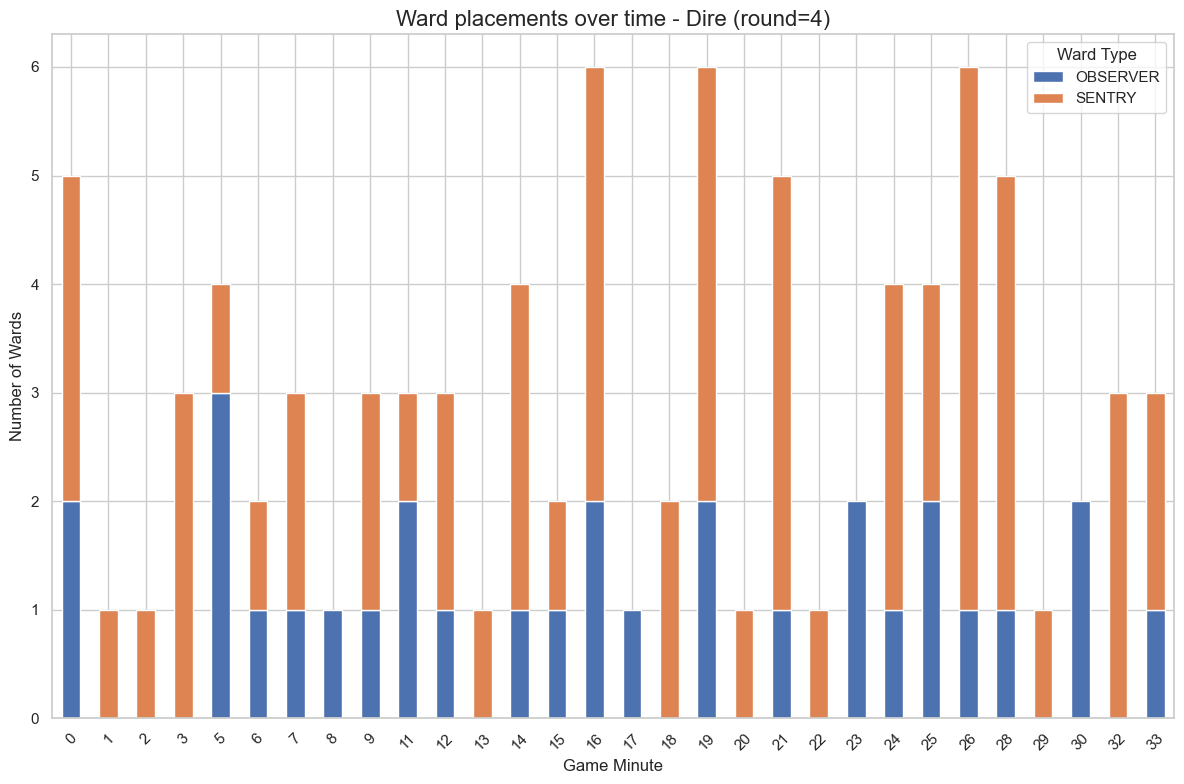

  Radiant: 29 OBSERVER, 54 SENTRY wards
  Dire: 30 OBSERVER, 58 SENTRY wards

Round 5 temporal analysis:


<Figure size 1500x600 with 0 Axes>

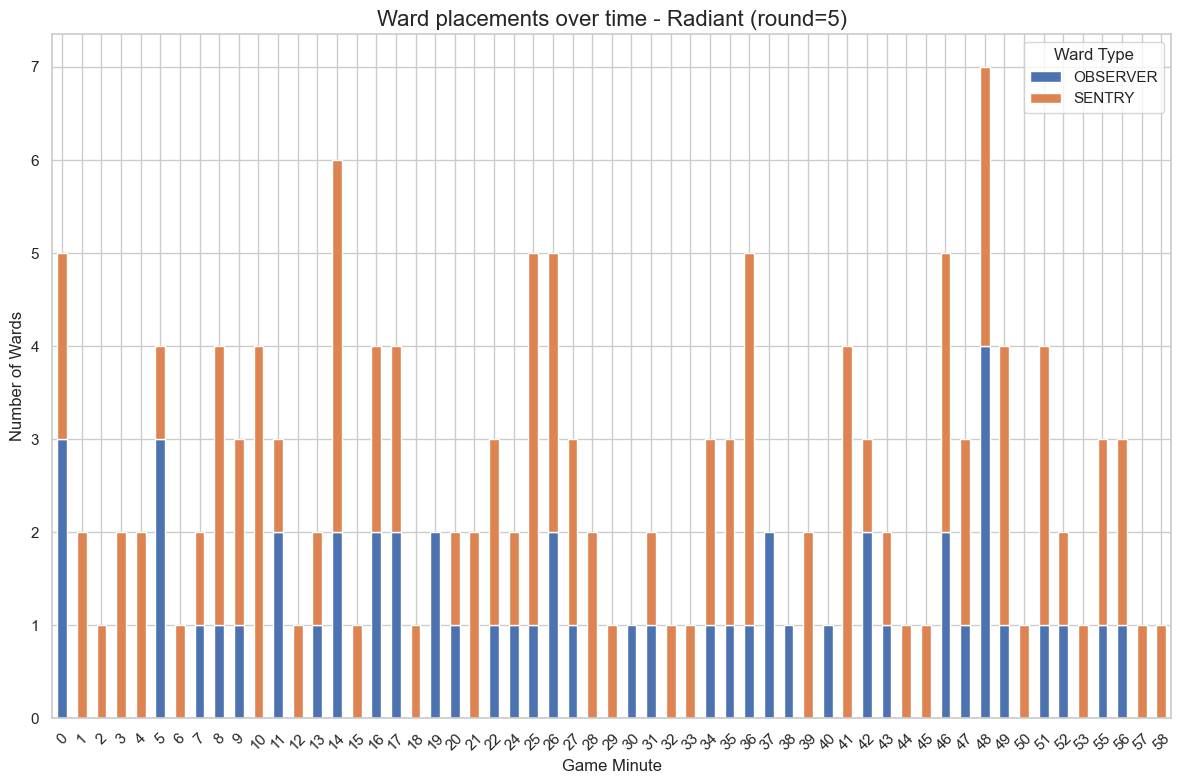

<Figure size 1500x600 with 0 Axes>

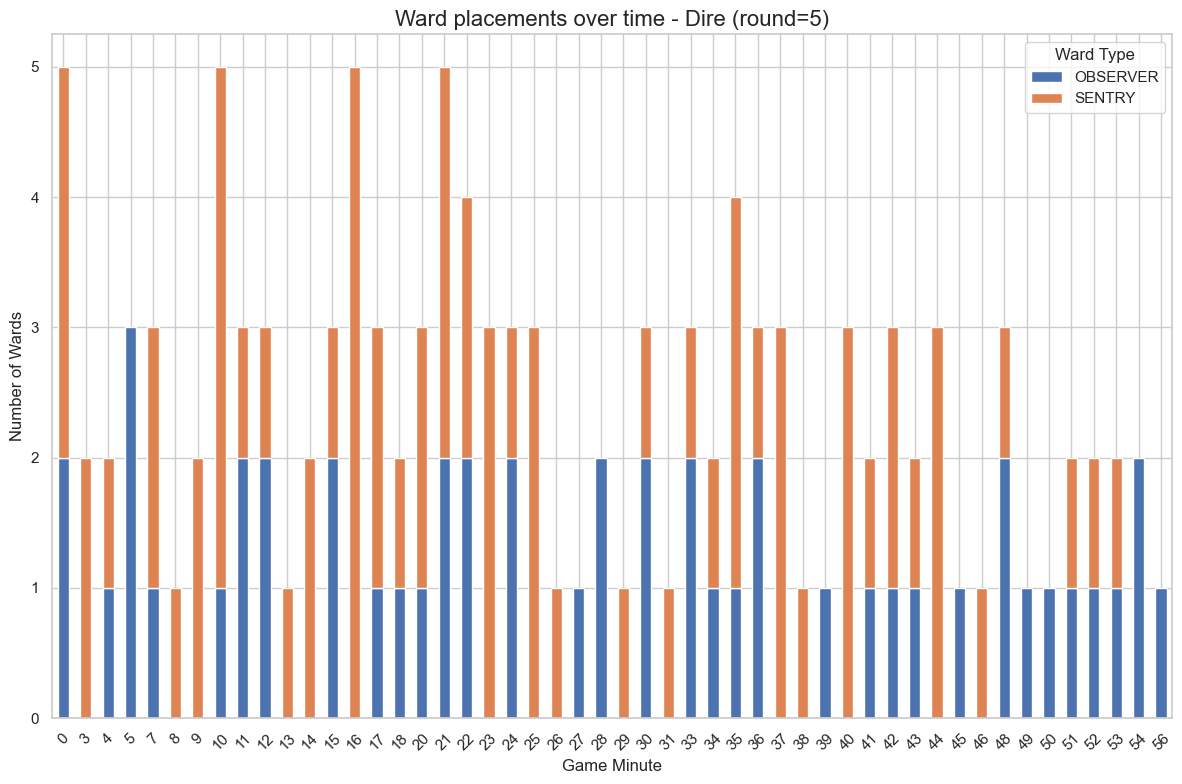

  Radiant: 51 OBSERVER, 96 SENTRY wards
  Dire: 49 OBSERVER, 72 SENTRY wards


In [10]:
# Perform temporal analysis with round splitting
print("Performing temporal analysis with round splitting...")

# Analyze each round
for round_id, df_round in df.groupby('round'):
    print(f"\nRound {round_id} temporal analysis:")
    
    # Plot time series for both teams
    plot_time_series(df_round, True)
    plot_time_series(df_round, False)
    
    # Print summary statistics
    for team_name, is_radiant in [('Radiant', True), ('Dire', False)]:
        team_data = df_round[df_round['isRadiant'] == is_radiant]
        observer_count = len(team_data[team_data['wardType'] == 'OBSERVER'])
        sentry_count = len(team_data[team_data['wardType'] == 'SENTRY'])
        print(f"  {team_name}: {observer_count} OBSERVER, {sentry_count} SENTRY wards")

In [11]:
# Contested areas analysis function
def contested_spots(df_data):
    """Find contested ward placement spots between teams"""
    rad = df_data[df_data['isRadiant'] == True][['positionX', 'positionY']].values
    dire = df_data[df_data['isRadiant'] == False][['positionX', 'positionY']].values
    
    if len(rad) == 0 or len(dire) == 0:
        return pd.DataFrame()
    
    # Find nearest Radiant ward for each Dire ward
    nbrs = NearestNeighbors(n_neighbors=1).fit(rad)
    dists, idxs = nbrs.kneighbors(dire)
    
    # Create results dataframe
    res = pd.DataFrame(dire, columns=['x','y'])
    res['dist_to_opponent'] = dists.flatten()
    res['cluster_cell'] = res.apply(lambda r: cell_id(r['x'], r['y'], cell_size=8), axis=1)
    
    return res.sort_values('dist_to_opponent')

In [12]:
# Analyze contested areas
print("Analyzing contested areas...")

# Find contested spots
contest_df = contested_spots(df)

if not contest_df.empty:
    # Show closest contested spots
    print(f"Found {len(contest_df)} contested spots")
    print("Closest contested spots:")
    print(contest_df.head(10)[['x', 'y', 'dist_to_opponent']])
    
    # Statistics
    avg_distance = contest_df['dist_to_opponent'].mean()
    min_distance = contest_df['dist_to_opponent'].min()
    print(f"\nAverage distance between opposing wards: {avg_distance:.2f} units")
    print(f"Minimum distance: {min_distance:.2f} units")
else:
    print("No contested spots found")

Analyzing contested areas...
Found 536 contested spots
Closest contested spots:
       x    y  dist_to_opponent
533  118   92               0.0
18   136  108               0.0
29   118  152               0.0
31   114  126               0.0
503   94  118               0.0
506   92  118               0.0
481   92  120               0.0
485   92  120               0.0
489   96  130               0.0
491  140  106               0.0

Average distance between opposing wards: 2.94 units
Minimum distance: 0.00 units


In [13]:
# Ward placement transition analysis
def build_transitions(df_full):
    """Build transition probabilities between ward placements"""
    trans = defaultdict(Counter)
    
    # Group by match, round, and team, then get placement sequences
    grouped = df_full.sort_values('time').groupby(['match_id','round','isRadiant'])['cell'].apply(list)
    
    for seq in grouped:
        for a, b in zip(seq, seq[1:]):
            trans[a][b] += 1
    
    return trans

# Build transitions for the entire dataset
print("Building transition analysis...")
transitions = build_transitions(df)

# Show some example transitions
if transitions:
    print(f"Found transitions from {len(transitions)} different cells")
    
    # Show top transitions from common cells
    common_cells = Counter()
    for source_cell, targets in transitions.items():
        common_cells[source_cell] = sum(targets.values())
    
    print("\nTop 5 most common starting cells:")
    for cell, count in common_cells.most_common(5):
        print(f"  Cell {cell}: {count} transitions")
        top_targets = transitions[cell].most_common(3)
        for target, freq in top_targets:
            print(f"    -> {target}: {freq} times")
else:
    print("No transitions built (not enough sequential data).")

Building transition analysis...
Found transitions from 164 different cells

Top 5 most common starting cells:
  Cell 14_16: 32 transitions
    -> 13_16: 3 times
    -> 16_12: 2 times
    -> 17_19: 2 times
  Cell 16_12: 23 transitions
    -> 14_16: 3 times
    -> 16_12: 2 times
    -> 15_13: 2 times
  Cell 15_15: 20 transitions
    -> 15_15: 3 times
    -> 14_11: 2 times
    -> 16_14: 1 times
  Cell 17_15: 20 transitions
    -> 18_13: 1 times
    -> 14_15: 1 times
    -> 17_15: 1 times
  Cell 20_11: 20 transitions
    -> 20_11: 4 times
    -> 16_17: 1 times
    -> 23_11: 1 times


In [14]:
# Recommendation system
def recommend_counters(df_data, team_is_radiant, top_k=5, eps=10):
    """Generate ward placement recommendations based on opponent patterns"""
    # Analyze opponent's ward placements
    enemy = df_data[df_data['isRadiant'] != team_is_radiant]
    enemy_clustered, summary = cluster_wards(enemy, eps=eps, min_samples=2)
    
    if summary.empty:
        return pd.DataFrame()
    
    # Generate recommendations
    top = summary.head(top_k).copy()
    recs = []
    
    for _, row in top.iterrows():
        cx = row['median_x']
        cy = row['median_y']
        freq = int(row['count'])
        mm = int(row['median_minute'])
        ward_t = row['common_wardType']
        
        # Determine recommendation based on ward type
        if ward_t == 'SENTRY':
            rec_text = (f"Enemy places SENTRY wards often at ({cx:.0f},{cy:.0f}) around minute {mm}. "
                       f"Consider contesting with hero presence or using your own SENTRY nearby.")
        else:  # OBSERVER
            rec_text = (f"Enemy places OBSERVER wards often at ({cx:.0f},{cy:.0f}) around minute {mm}. "
                       f"Consider pre-placing SENTRY wards to deward or contest with hero presence.")
        
        recs.append({
            'cluster': int(row['cluster']),
            'x': float(cx),
            'y': float(cy),
            'freq': freq,
            'typical_minute': mm,
            'ward_type': ward_t,
            'recommendation': rec_text
        })
    
    return pd.DataFrame(recs)

# Generate recommendations for both teams
print("Generating strategic recommendations...")

print("\nRadiant recommendations:")
recs_rad = recommend_counters(df, team_is_radiant=True)
if not recs_rad.empty:
    for _, rec in recs_rad.iterrows():
        print(f"  {rec['recommendation']}")
else:
    print("  No strong patterns detected for recommendations")
    
print("\nDire recommendations:")
recs_dire = recommend_counters(df, team_is_radiant=False)
if not recs_dire.empty:
    for _, rec in recs_dire.iterrows():
        print(f"  {rec['recommendation']}")
else:
    print("  No strong patterns detected for recommendations")

Generating strategic recommendations...

Radiant recommendations:
  Enemy places SENTRY wards often at (124,134) around minute 23. Consider contesting with hero presence or using your own SENTRY nearby.
  Enemy places SENTRY wards often at (164,92) around minute 9. Consider contesting with hero presence or using your own SENTRY nearby.
  Enemy places OBSERVER wards often at (158,70) around minute 20. Consider pre-placing SENTRY wards to deward or contest with hero presence.
  Enemy places SENTRY wards often at (187,116) around minute 17. Consider contesting with hero presence or using your own SENTRY nearby.
  Enemy places OBSERVER wards often at (66,178) around minute 15. Consider pre-placing SENTRY wards to deward or contest with hero presence.

Dire recommendations:
  Enemy places SENTRY wards often at (122,122) around minute 21. Consider contesting with hero presence or using your own SENTRY nearby.
  Enemy places SENTRY wards often at (70,182) around minute 23. Consider contesting

In [15]:
# Ward efficiency analysis (based on SPAWN/DESPAWN pairs)
print("Performing ward efficiency analysis...")

# For this analysis, we need to match SPAWN and DESPAWN events
# We'll use the indexId to match pairs
spawn_events = df[df['action'] == 'SPAWN'].copy()
despawn_events = df[df['action'] == 'DESPAWN'].copy()

# Merge spawn and despawn events on indexId
ward_lifespans = pd.merge(
    spawn_events[['indexId', 'time', 'positionX', 'positionY', 'isRadiant', 'wardType', 'round']],
    despawn_events[['indexId', 'time']],
    on='indexId',
    how='inner',
    suffixes=('_spawn', '_despawn')
)

# Calculate lifespan
ward_lifespans['lifespan'] = ward_lifespans['time_despawn'] - ward_lifespans['time_spawn']

print(f"Matched {len(ward_lifespans)} ward spawn/despawn pairs")

# Basic statistics
print(f"\nWard lifespan statistics:")
print(f"  Mean lifespan: {ward_lifespans['lifespan'].mean():.1f} seconds ({ward_lifespans['lifespan'].mean()/60:.1f} minutes)")
print(f"  Median lifespan: {ward_lifespans['lifespan'].median():.1f} seconds ({ward_lifespans['lifespan'].median()/60:.1f} minutes)")
print(f"  Min lifespan: {ward_lifespans['lifespan'].min():.1f} seconds")
print(f"  Max lifespan: {ward_lifespans['lifespan'].max():.1f} seconds ({ward_lifespans['lifespan'].max()/60:.1f} minutes)")

# Analysis by ward type
print(f"\nBy ward type:")
for ward_type in ward_lifespans['wardType'].unique():
    type_data = ward_lifespans[ward_lifespans['wardType'] == ward_type]
    print(f"  {ward_type}: {type_data['lifespan'].mean()/60:.1f} min average lifespan ({len(type_data)} wards)")

# Analysis by team
print(f"\nBy team:")
for is_radiant, team_name in [(True, 'Radiant'), (False, 'Dire')]:
    team_data = ward_lifespans[ward_lifespans['isRadiant'] == is_radiant]
    print(f"  {team_name}: {team_data['lifespan'].mean()/60:.1f} min average lifespan ({len(team_data)} wards)")

# Analysis by round
print(f"\nBy round:")
for round_id in sorted(ward_lifespans['round'].unique()):
    round_data = ward_lifespans[ward_lifespans['round'] == round_id]
    print(f"  Round {round_id}: {round_data['lifespan'].mean()/60:.1f} min average lifespan ({len(round_data)} wards)")

Performing ward efficiency analysis...
Matched 673 ward spawn/despawn pairs

Ward lifespan statistics:
  Mean lifespan: 266.2 seconds (4.4 minutes)
  Median lifespan: 360.0 seconds (6.0 minutes)
  Min lifespan: -2860.0 seconds
  Max lifespan: 3128.0 seconds (52.1 minutes)

By ward type:
  OBSERVER: 3.8 min average lifespan (240 wards)
  SENTRY: 4.8 min average lifespan (433 wards)

By team:
  Radiant: 4.6 min average lifespan (345 wards)
  Dire: 4.3 min average lifespan (328 wards)

By round:
  Round 1: 3.4 min average lifespan (163 wards)
  Round 2: 5.7 min average lifespan (106 wards)
  Round 3: 5.5 min average lifespan (122 wards)
  Round 4: 5.7 min average lifespan (110 wards)
  Round 5: 3.2 min average lifespan (172 wards)


In [16]:
# Advanced spatial pattern analysis
print("Performing advanced spatial pattern analysis...")

# Analyze ward placement distribution across the map
def analyze_spatial_distribution(df_data):
    """Analyze spatial distribution patterns"""
    # Divide map into quadrants
    mid_x, mid_y = MAP_WIDTH/2, MAP_HEIGHT/2
    
    def quadrant(x, y):
        if x < mid_x and y < mid_y:
            return "Bottom-Left"
        elif x >= mid_x and y < mid_y:
            return "Bottom-Right"
        elif x < mid_x and y >= mid_y:
            return "Top-Left"
        else:
            return "Top-Right"
    
    df_data['quadrant'] = df_data.apply(lambda r: quadrant(r['positionX'], r['positionY']), axis=1)
    
    # Count by quadrant
    quadrant_counts = df_data['quadrant'].value_counts()
    
    return quadrant_counts

# Overall distribution
overall_dist = analyze_spatial_distribution(df)
print("Overall placement distribution:")
for quadrant, count in overall_dist.items():
    print(f"  {quadrant}: {count} wards ({count/len(df)*100:.1f}%)")

# By team
for team_name, is_radiant in [('Radiant', True), ('Dire', False)]:
    team_data = df[df['isRadiant'] == is_radiant]
    if len(team_data) > 0:
        team_dist = analyze_spatial_distribution(team_data)
        print(f"\n{team_name} distribution:")
        for quadrant, count in team_dist.items():
            print(f"  {quadrant}: {count} wards ({count/len(team_data)*100:.1f}%)")

# Distance from common strategic points
def distance_analysis(df_data):
    """Analyze distances to key strategic points"""
    # Define some key strategic points (approximate)
    # These would be more accurate with actual map data
    strategic_points = {
        'Radiant_Ancient': (20, 20),
        'Dire_Ancient': (150, 280),
        'River_Center': (86, 150)  # Approximate center based on example
    }
    
    results = {}
    for point_name, (px, py) in strategic_points.items():
        distances = np.sqrt((df_data['positionX'] - px)**2 + (df_data['positionY'] - py)**2)
        results[point_name] = {
            'mean_distance': distances.mean(),
            'median_distance': np.median(distances),
            'min_distance': distances.min(),
            'max_distance': distances.max()
        }
    
    return results

print(f"\nDistance to strategic points:")
distance_stats = distance_analysis(df)
for point, stats in distance_stats.items():
    print(f"  {point}:")
    print(f"    Average distance: {stats['mean_distance']:.0f} units")
    print(f"    Median distance: {stats['median_distance']:.0f} units")

Performing advanced spatial pattern analysis...
Overall placement distribution:
  Bottom-Left: 1083 wards (100.0%)

Radiant distribution:
  Bottom-Left: 547 wards (100.0%)

Dire distribution:
  Bottom-Left: 536 wards (100.0%)

Distance to strategic points:
  Radiant_Ancient:
    Average distance: 154 units
    Median distance: 155 units
  Dire_Ancient:
    Average distance: 158 units
    Median distance: 158 units
  River_Center:
    Average distance: 55 units
    Median distance: 50 units


In [17]:
# Final summary
print("=== ANALYSIS SUMMARY ===")
print(f"Total ward events analyzed: {len(df)}")
print(f"Number of rounds: {df['round'].nunique()}")
print(f"\nKey findings:")

# Ward type distribution
ward_type_counts = df['wardType'].value_counts()
for ward_type, count in ward_type_counts.items():
    print(f"  {ward_type} wards: {count} ({count/len(df)*100:.1f}%)")

# Team distribution
team_counts = df['isRadiant'].value_counts()
print(f"  Radiant wards: {team_counts[True]} ({team_counts[True]/len(df)*100:.1f}%)")
print(f"  Dire wards: {team_counts[False]} ({team_counts[False]/len(df)*100:.1f}%)")

# Temporal patterns
early_game = df[df['minute'] <= 10]
mid_game = df[(df['minute'] > 10) & (df['minute'] <= 25)]
late_game = df[df['minute'] > 25]
print(f"\nTemporal distribution:")
print(f"  Early game (0-10 min): {len(early_game)} wards ({len(early_game)/len(df)*100:.1f}%)")
print(f"  Mid game (10-25 min): {len(mid_game)} wards ({len(mid_game)/len(df)*100:.1f}%)")
print(f"  Late game (25+ min): {len(late_game)} wards ({len(late_game)/len(df)*100:.1f}%)")

print(f"\nAnalysis complete!")

=== ANALYSIS SUMMARY ===
Total ward events analyzed: 1083
Number of rounds: 5

Key findings:
  SENTRY wards: 691 (63.8%)
  OBSERVER wards: 392 (36.2%)
  Radiant wards: 547 (50.5%)
  Dire wards: 536 (49.5%)

Temporal distribution:
  Early game (0-10 min): 254 wards (23.5%)
  Mid game (10-25 min): 401 wards (37.0%)
  Late game (25+ min): 428 wards (39.5%)

Analysis complete!
